In [ ]:
import sys
sys.path.append('..')

In [1]:
import pickle

import numpy as np
import torch
import dgl
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# from src.env.environment import FurnaceEnvironment
from src.model.get_model import get_model
from src.utils.preprocess_data import preprocess_data
from src.utils.fix_seed import fix_seed
fix_seed()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Using backend: pytorch


In [2]:
def model_prediction_test(model, test_data, test_config):
    test_states = test_data['state_list']
    test_actions = test_data['action_list']
    test_graphs = test_data['graph_list']

    receding_history = test_config['receding_history']
    receding_horizon = test_config['receding_horizon']
    state_scaler = test_config['state_scaler']
    action_scaler = test_config['action_scaler']

    with torch.no_grad():
        test_history_xs_list, test_history_us_list, test_us_list, test_ys_list, test_graph_list, test_idxs = preprocess_data(
            states=test_states,
            actions=test_actions,
            graphs=test_graphs,
            receding_history=receding_history,
            receding_horizon=receding_horizon,
            state_scaler=state_scaler,
            action_scaler=action_scaler,
            device=DEVICE)
        test_batch_size = test_idxs.shape[0]
        test_gs = dgl.batch([test_graph_list[test_idxs[idx, 0]] for idx in range(test_batch_size)])
        test_history_x = torch.cat(
            [test_history_xs_list[test_idxs[idx, 0]][test_idxs[idx, 1]] for idx in range(test_batch_size)])
        test_history_u = torch.cat(
            [test_history_us_list[test_idxs[idx, 0]][test_idxs[idx, 1]] for idx in range(test_batch_size)])
        test_u = torch.cat([test_us_list[test_idxs[idx, 0]][test_idxs[idx, 1]] for idx in range(test_batch_size)])
        test_y = torch.cat([test_ys_list[test_idxs[idx, 0]][test_idxs[idx, 1]] for idx in range(test_batch_size)])
        hs = model.filter_history(test_gs, test_history_x, test_history_u)
        predicted_y = model.multi_step_prediction(test_gs, hs, test_u)
    return test_y, predicted_y


def model_increasing_check(model, test_data, test_config):
    test_states = test_data['state_list']
    test_actions = test_data['action_list']
    test_graphs = test_data['graph_list']

    receding_history = test_config['receding_history']
    receding_horizon = test_config['receding_horizon']
    state_scaler = test_config['state_scaler']
    action_scaler = test_config['action_scaler']

c:\users\song chi hyeon\anaconda3\envs\mpc37\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
c:\users\song chi hyeon\anaconda3\envs\mpc37\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


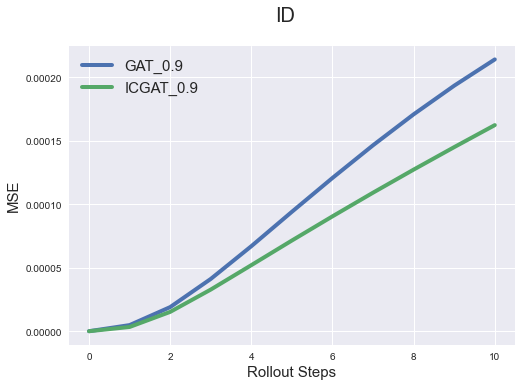

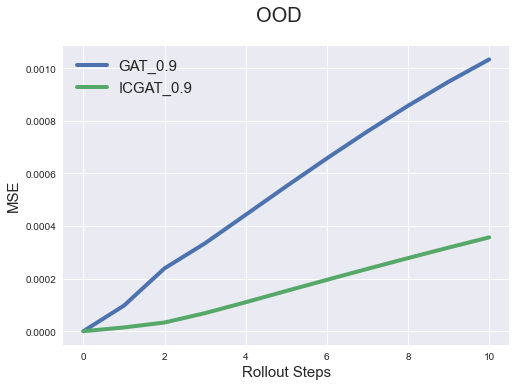

In [5]:
with open('data/env_config.pkl', 'rb') as f:
    env_config = pickle.load(f)
num_cells = env_config['num_cells']
dt = env_config['dt']
epsilon = env_config['epsilon']
domain_range = env_config['domain_range']
action_min = env_config['action_min']
action_max = env_config['action_max']
state_scaler = env_config['state_scaler']
action_scaler = env_config['action_scaler']
x_dim = 1
u_dim = 1
receding_history = 5
receding_horizon = 10

test_config = {
    'receding_history': receding_history,
    'receding_horizon': receding_horizon,
    'state_scaler': state_scaler,
    'action_scaler': action_scaler
}

# Prepare to load models
model_names = ['GAT', 'ICGAT']
data_ratio_list = [0.9]
hidden_dim = 64
is_convex = False

# Prepare test data
test_data_path_list = ['data/ground_truth/test_data.pkl', 'data/ground_truth/out_distribution_data.pkl']
fig_title_list = ['ID', 'OOD']

for (idx, test_data_path) in enumerate(test_data_path_list):
    with open(test_data_path, 'rb') as f:
        test_data = pickle.load(f)
    criteria = torch.nn.SmoothL1Loss(reduction='none')
    for data_ratio in data_ratio_list:
        fig, axes = plt.subplots(1, 1)
        true_ys = []
        predicted_ys = []
        arg_dif_list = []
        for model_name in model_names:
            saved_model_path = 'saved_model/{}_{}.pt'.format(model_name, data_ratio)
            model = get_model(model_name, hidden_dim, is_convex, saved_model_path).to(DEVICE)
            true_y, predicted_y = model_prediction_test(model, test_data, test_config)
            true_ys.append(true_y)
            predicted_ys.append(predicted_y)
            dif = criteria(true_y, predicted_y)[:, :, 0]
            arg_dif_list.append(np.argsort(dif.cpu().detach().numpy(), axis=0))
            dif_mean = torch.mean(dif, dim=0).cpu().detach().numpy()
            dif_mean = np.concatenate([np.zeros(1), dif_mean])
            dif_std = torch.std(dif, dim=0).cpu().detach().numpy()
            dif_std = np.concatenate([np.zeros(1), dif_std])
            axes.plot(dif_mean, label='{}_{}'.format(model_name, data_ratio), linewidth=4)
            """saved_model_path = 'saved_model/curr_model/{}_{}.pt'.format(model_name, data_ratio)
            model = get_model(model_name, hidden_dim, is_convex, saved_model_path).to(DEVICE)
            true_y, predicted_y = model_prediction_test(model, test_data, test_config)
            true_ys.append(true_y)
            predicted_ys.append(predicted_y)
            dif = criteria(true_y, predicted_y)[:, :, 0]
            arg_dif_list.append(np.argsort(dif.cpu().detach().numpy(), axis=0))
            dif_mean = torch.mean(dif, dim=0).cpu().detach().numpy()
            dif_mean = np.concatenate([np.zeros(1), dif_mean])
            dif_std = torch.std(dif, dim=0).cpu().detach().numpy()
            dif_std = np.concatenate([np.zeros(1), dif_std])
            axes.plot(dif_mean, label='Current_{}'.format(model_name), linewidth=4)"""
        axes.legend(fontsize=15)
        axes.set_xlabel('Rollout Steps', size=15)
        axes.set_ylabel('MSE', size=15)
        fig.suptitle(fig_title_list[idx], size=20)
        fig.show()
